### Setup for data loading

In [2]:
import cv2
import h5py
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T
import torch.nn.functional as F  # useful stateless functions

from matplotlib.pyplot import plot, xlabel, ylabel, title, imshow
from matplotlib import pyplot as plt

import numpy as np
import random

In [3]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

using device: cuda


### Loading human detection training data

In [4]:
# Load human detection training data.
# Each human sample is stored as lists of
# bbox[iClip][iFrame] = narray(N,D)
# where N = number of people in the frame, and 
# D = 4 (x, y, width, height)
hf = h5py.File('truth_data/ground_truth_data_train.mat', 'r')
data = hf.get('ground_truth_data')['list']
bbox = {}
for d in data[0]:
    imgname = ''.join([chr(x) for x in hf[d]['imgname'][:]])
    iClip = imgname[4:7]
    iFrame = int(imgname[8:12])
    if iClip not in bbox:
        bbox[iClip] = {}
    bbox[iClip][iFrame] = np.int_(hf[d]['bbox'][:].T/6)

In [5]:
# Check number of human dectection samples.
nData = 0
nFrame = 0
for iClip in bbox:
    for iFrame in bbox[iClip]:
        nData += bbox[iClip][iFrame].shape[0]
        nFrame += 1
nData, nFrame

(1607, 420)

### Training RNN with full image
We try to apply RNN on the full image of each frame. The human detection data is used as the hidden input for the next frame. Since we have limited number of 'labeled' frames, we will only use the labeled frames to update our model.

In [6]:
# Save clips 
frame_every = 20
path = 'videos/'
frames = {}

iClip = '001'
videofile = path+'mv2_'+iClip+'.avi'
cap = cv2.VideoCapture(videofile)
X_sample = []
y_sample = []
for i in range(1):
    for iFrame in range(1+i*200, 1+(i+1)*200+1, frame_every):
        cap.set(1, iFrame)
        ret, frame = cap.read()
        if ret:
                X_sample.append(torch.from_numpy(frame))
        if (iFrame-1)%200 == 0:
            tmp = np.zeros(X_sample[0].shape[0:2])
            for d in bbox[iClip][iFrame]:
                x, y, dx, dy = d
                tmp[y:y+dy, x:x+dx] = 1
            y_sample.append(torch.from_numpy(tmp))


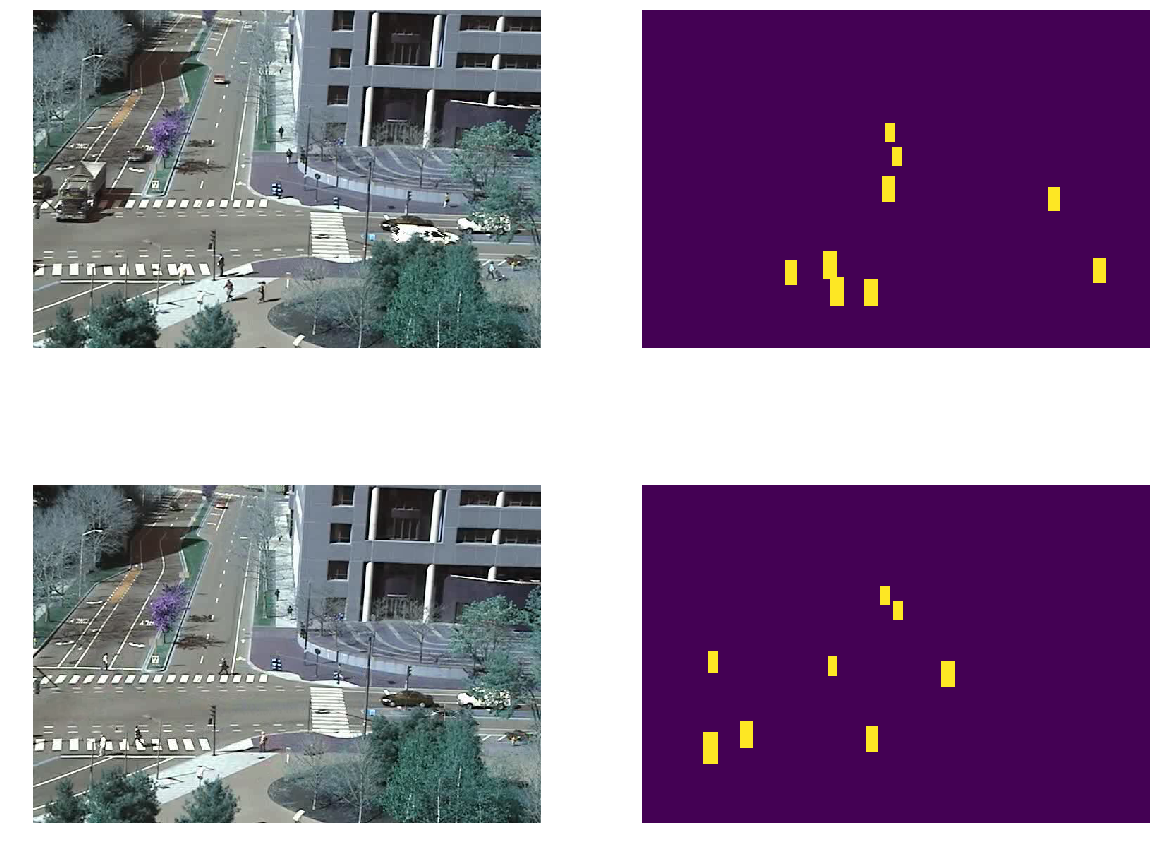

In [7]:
# Check y_sample data
fig = plt.figure(figsize=(20,16))
ax = fig.add_subplot(2,2,1)
ax.axis('off')
ax.imshow(X_sample[0].to(dtype=torch.uint8))
ax = fig.add_subplot(2,2,2)
ax.axis('off')
ax.imshow(y_sample[0].to(dtype=torch.uint8))

ax = fig.add_subplot(2,2,3)
ax.axis('off')
ax.imshow(X_sample[10].to(dtype=torch.uint8))
ax = fig.add_subplot(2,2,4)
ax.axis('off')
ax.imshow(y_sample[1].to(dtype=torch.uint8))

In [23]:
# Define a RNN model that we want to use
class VideoRNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.cn1 = nn.Conv2d(3, 32, 3, padding=1)
        nn.init.kaiming_normal_(self.cn1.weight)
        self.cn11 = nn.Conv2d(1, 32, 3, padding=1)
        nn.init.kaiming_normal_(self.cn11.weight)
        self.cn2 = nn.Conv2d(32, 16, 3, padding=1)
        nn.init.kaiming_normal_(self.cn2.weight)
        self.cn3 = nn.Conv2d(16, 8, 3, padding=1)
        nn.init.kaiming_normal_(self.cn3.weight)
        self.cn4 = nn.Conv2d(8, 4, 3, padding=1)
        nn.init.kaiming_normal_(self.cn4.weight)
        self.cn5 = nn.Conv2d(4, 2, 3, padding=1)
        nn.init.kaiming_normal_(self.cn5.weight)
    
    def forward(self, x, h):
        x = self.cn1(x)
        h = self.cn11(h)
        h = F.relu(x+h)
        h = F.relu(self.cn2(h))
        h = F.relu(self.cn4(F.relu(self.cn3(h))))
        scores = self.cn5(h)
        return scores
        

In [34]:
def check_accuracy_RNN(X, y, model, H=torch.zeros([0])):
    if H.size == 0:
        H = .5*torch.ones(y[0].shape)
    H = H.unsqueeze(0).unsqueeze(0).to(dtype=dtype)
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        N = len(X)
        for i in range(N):
            xi = X[i].permute(2,0,1).unsqueeze(0).to(dtype=dtype)  # move to device, e.g. GPU
            H = model(xi, H)
            if i%10 == 0:
                yi = y[int(i/10)].unsqueeze(0).to(dtype=torch.long)
                preds = H[0].argmax(dim=1)
                print(preds.shape)
                fig2 = plt.figure(figsize=(20,8))
                ax = fig.add_subplot(1,2,1)
                ax.axis('off')
                ax.imshow(yi[0].to(dtype=torch.uint8))
                ax = fig.add_subplot(1,2,2)
                ax.axis('off')
                ax.imshow(preds.to(dtype=torch.uint8))
            H = (H[:,1,:,:] - H[:,0,:,:]).unsqueeze(0)
                

def train_model_RNN(X, y, model, optimizer, epochs=1, H=torch.zeros([0])):
    if H.size==0:
        H = .5*torch.ones(y[0].shape)
    H = H.unsqueeze(0).unsqueeze(0).to(dtype=dtype)
    model = model#.to(device=device)  # move the model parameters to CPU/GPU
    N = len(X)
    t = 0
    train_acc = []
    val_acc = []
    fig = plt.figure(figsize=(20,20))
    for e in range(epochs):
        for i in range(N):
            Xt = X[t].permute(2,0,1).unsqueeze(0).to(dtype=dtype)  # move to device, e.g. GPU
            H = model(Xt, H)
            ax = fig.add_subplot(4,3,t+1)
            ax.axis('off')
            ax.imshow(H[0].argmax(dim=0).to(dtype=torch.uint8))
            
            if t%10 < 3:
                yt = y[int(t/10)].unsqueeze(0).to(dtype=torch.long)
                loss = F.cross_entropy(H, yt)
                optimizer.zero_grad()
                loss.backward(retain_graph=True)
                optimizer.step()
                
            H = (H[:,1,:,:] - H[:,0,:,:]).unsqueeze(0)
            t += 1


In [35]:
model = VideoRNN()
optimizer = optim.Adam(model.parameters(), lr=5.e-5, betas=(0.9, 0.999))

100%|██████████| 10/10 [03:24<00:00, 20.43s/it]


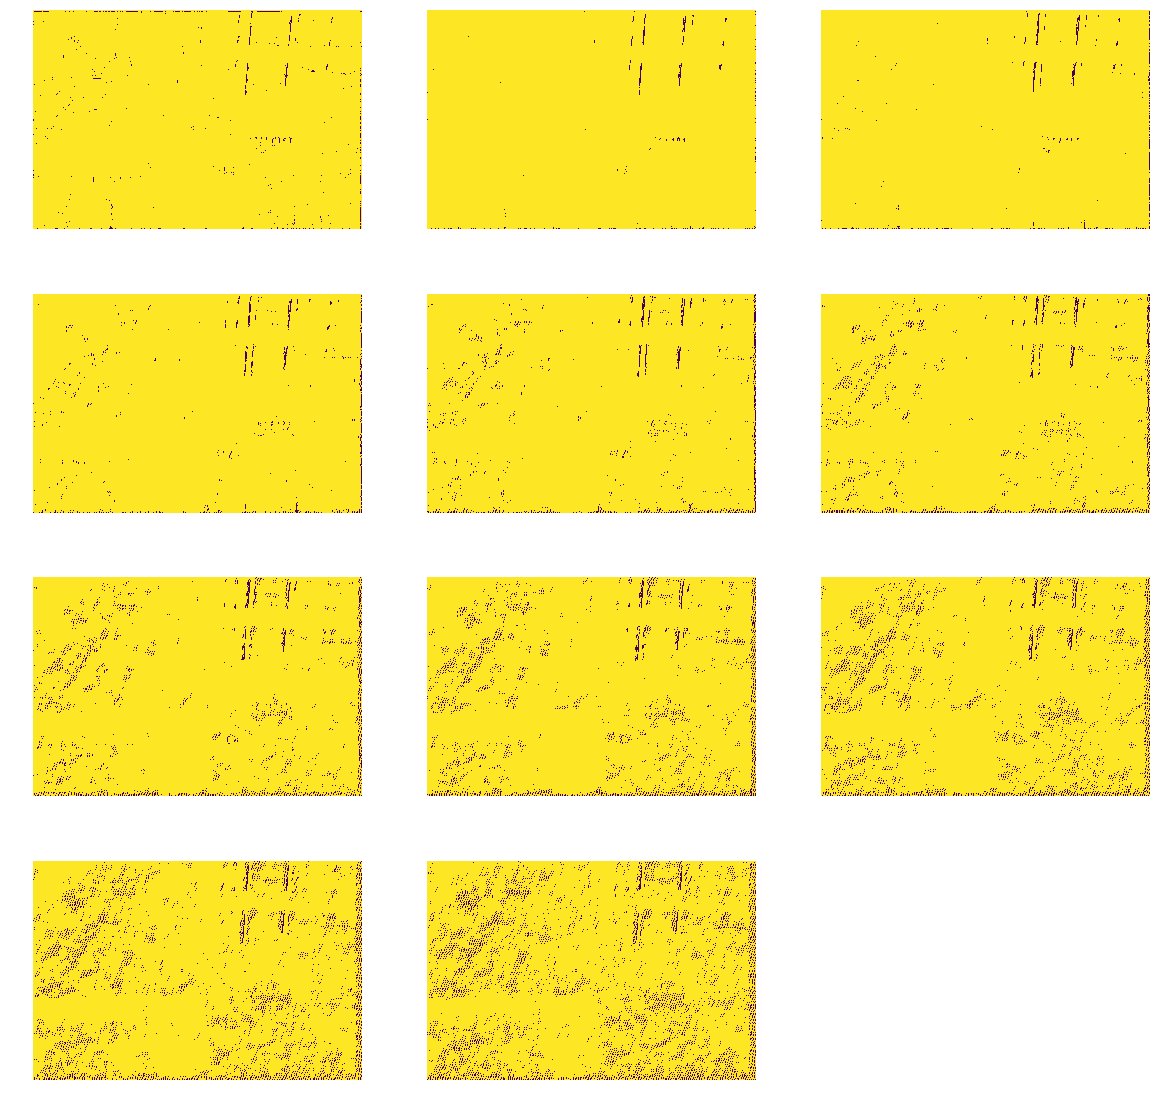

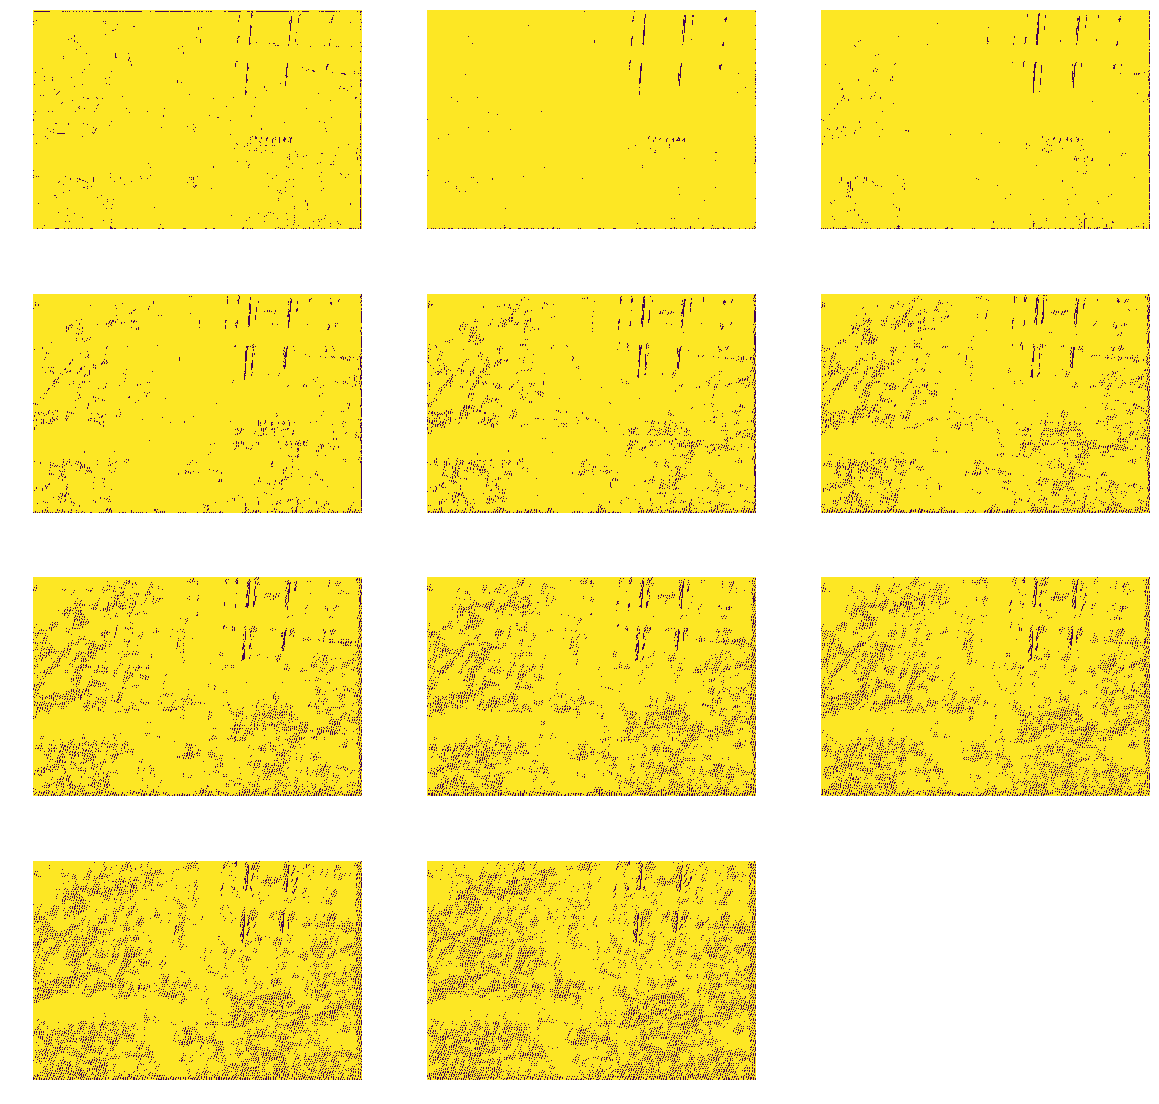

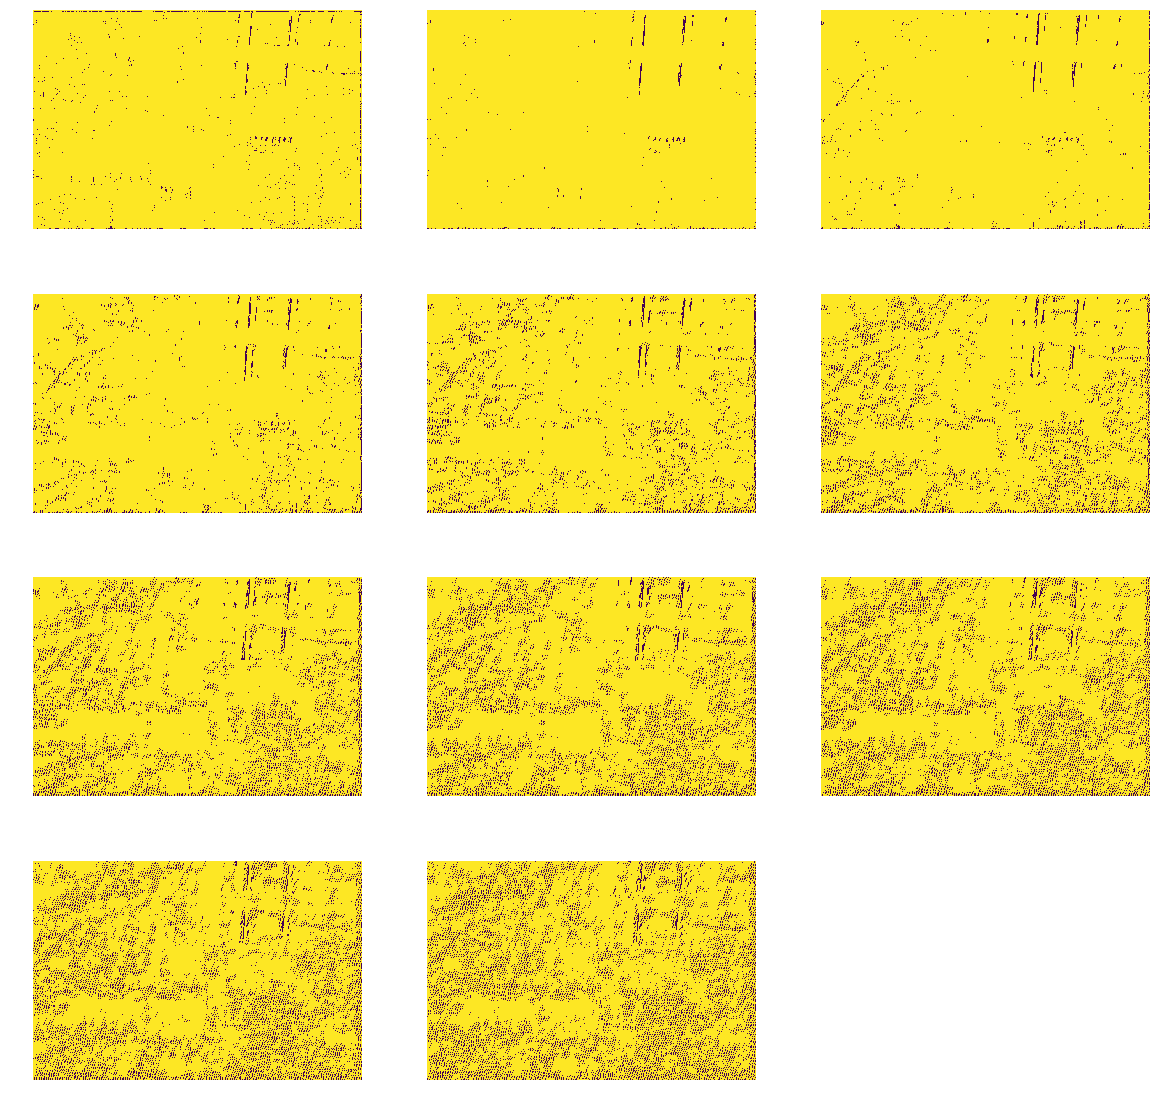

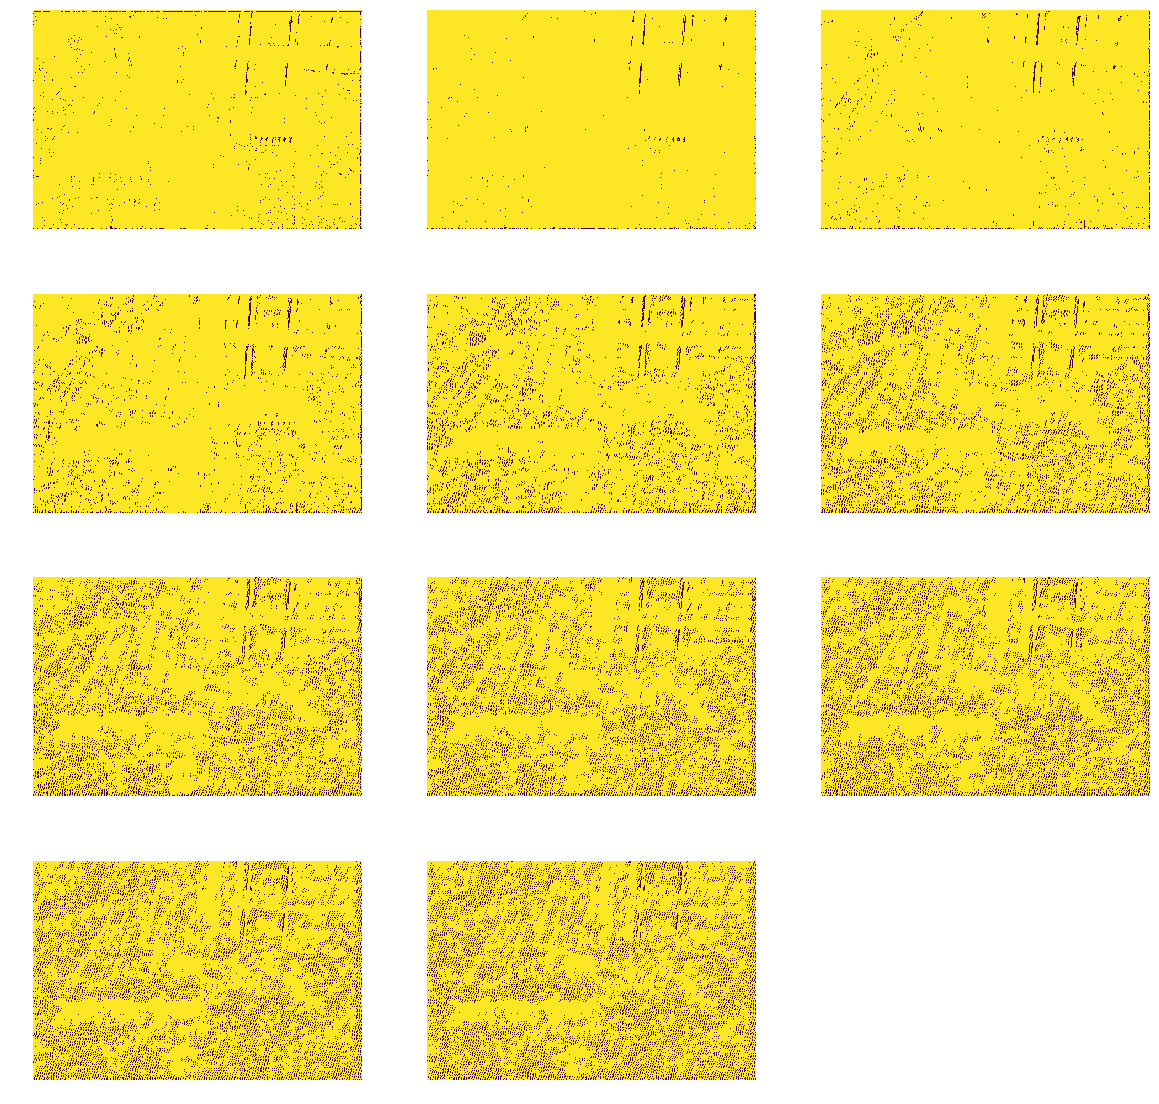

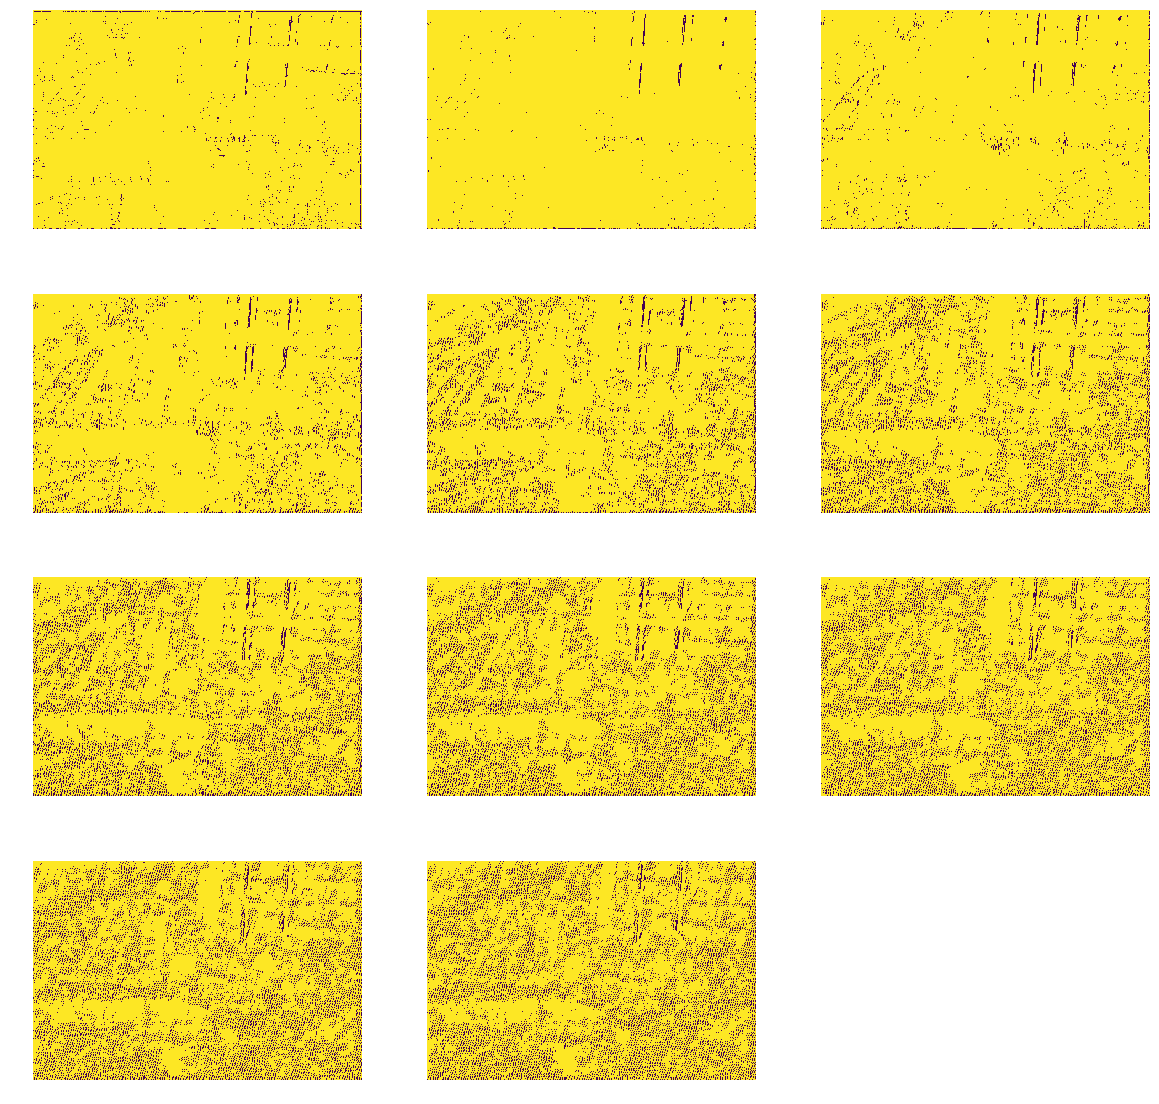

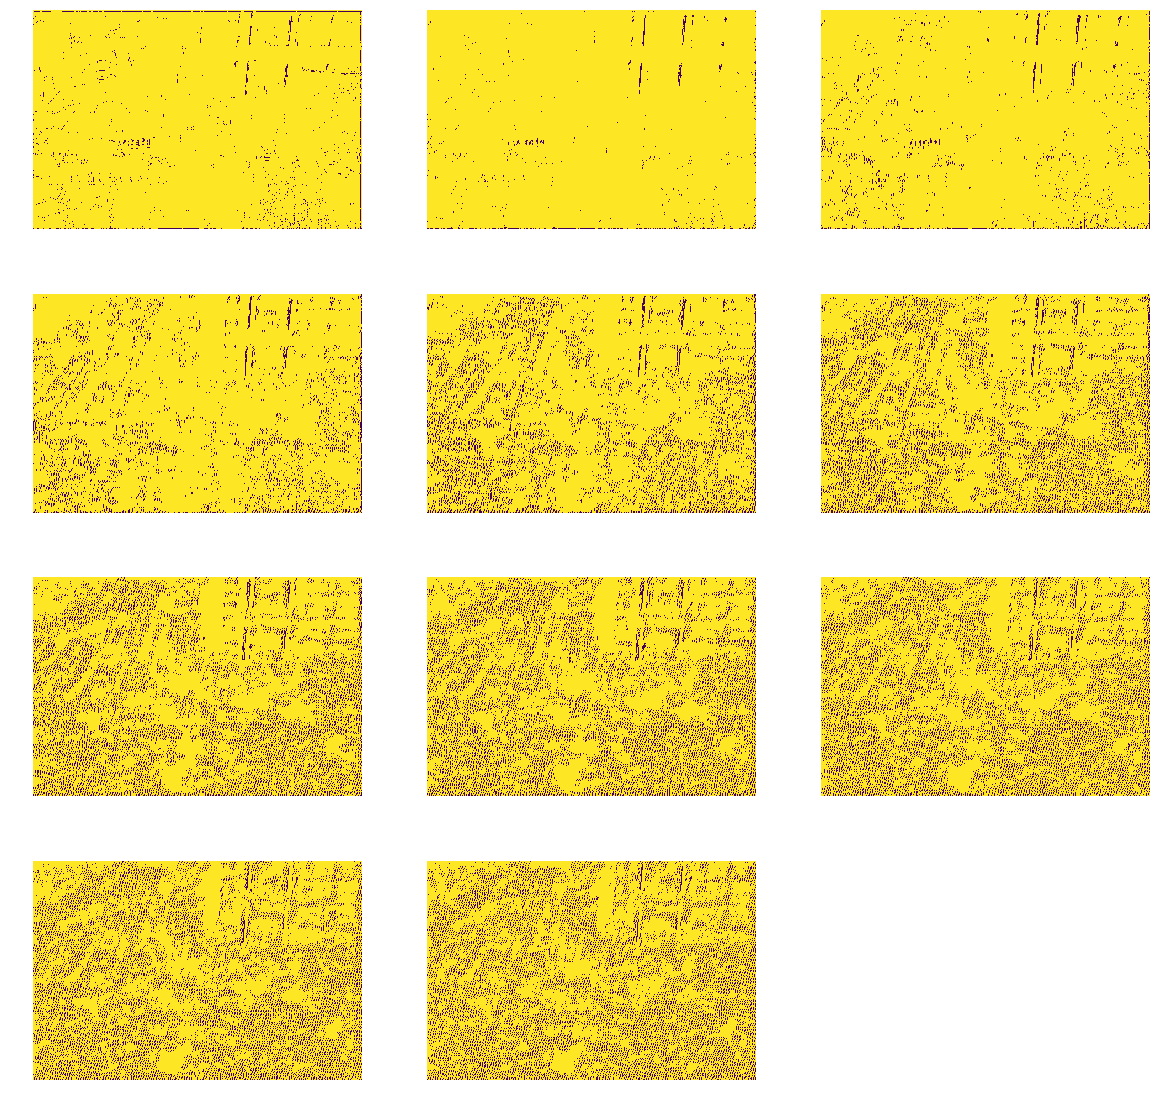

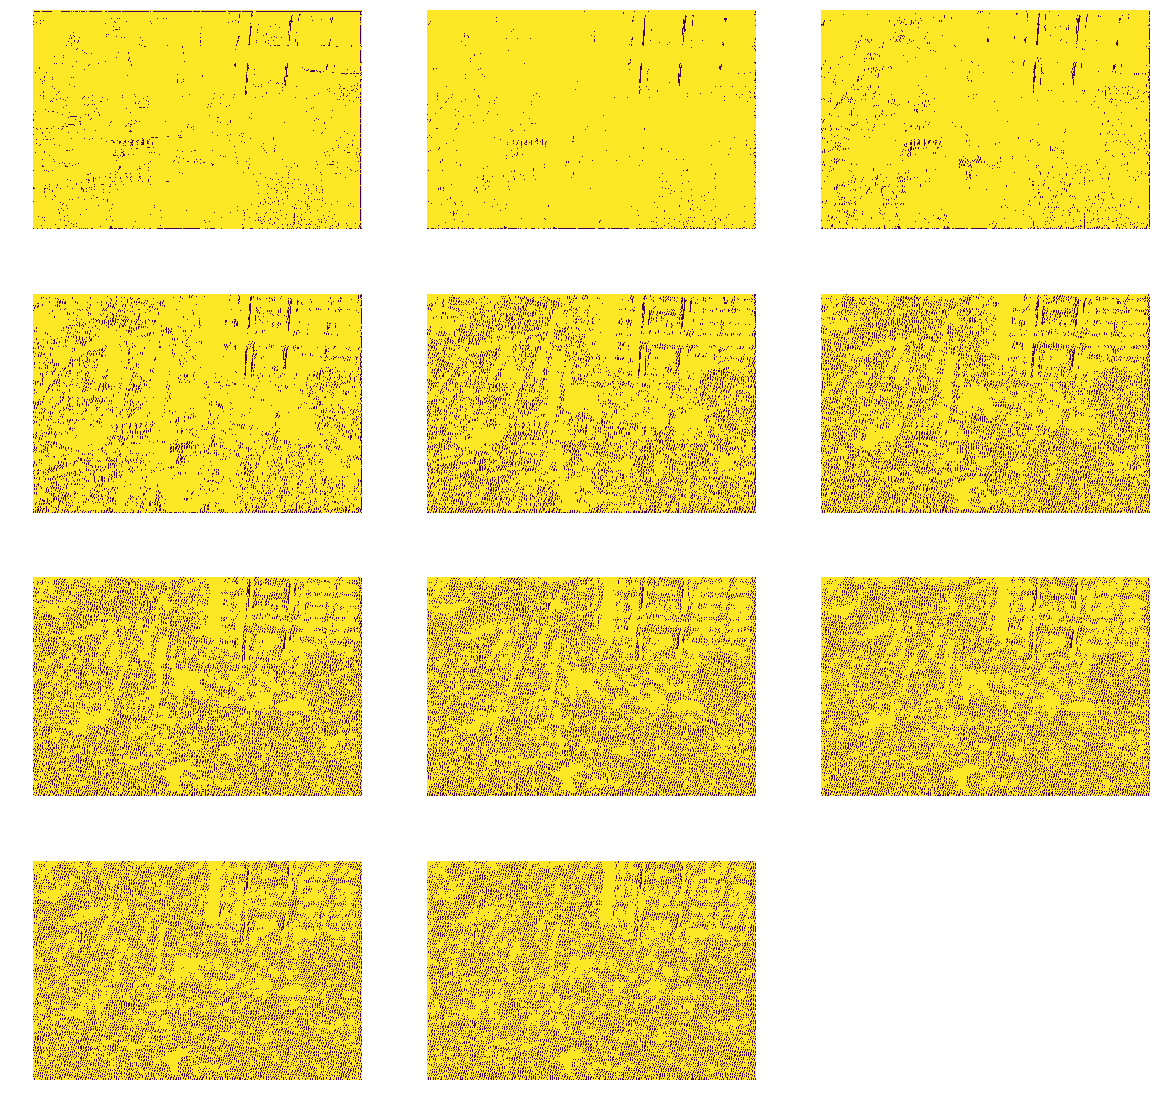

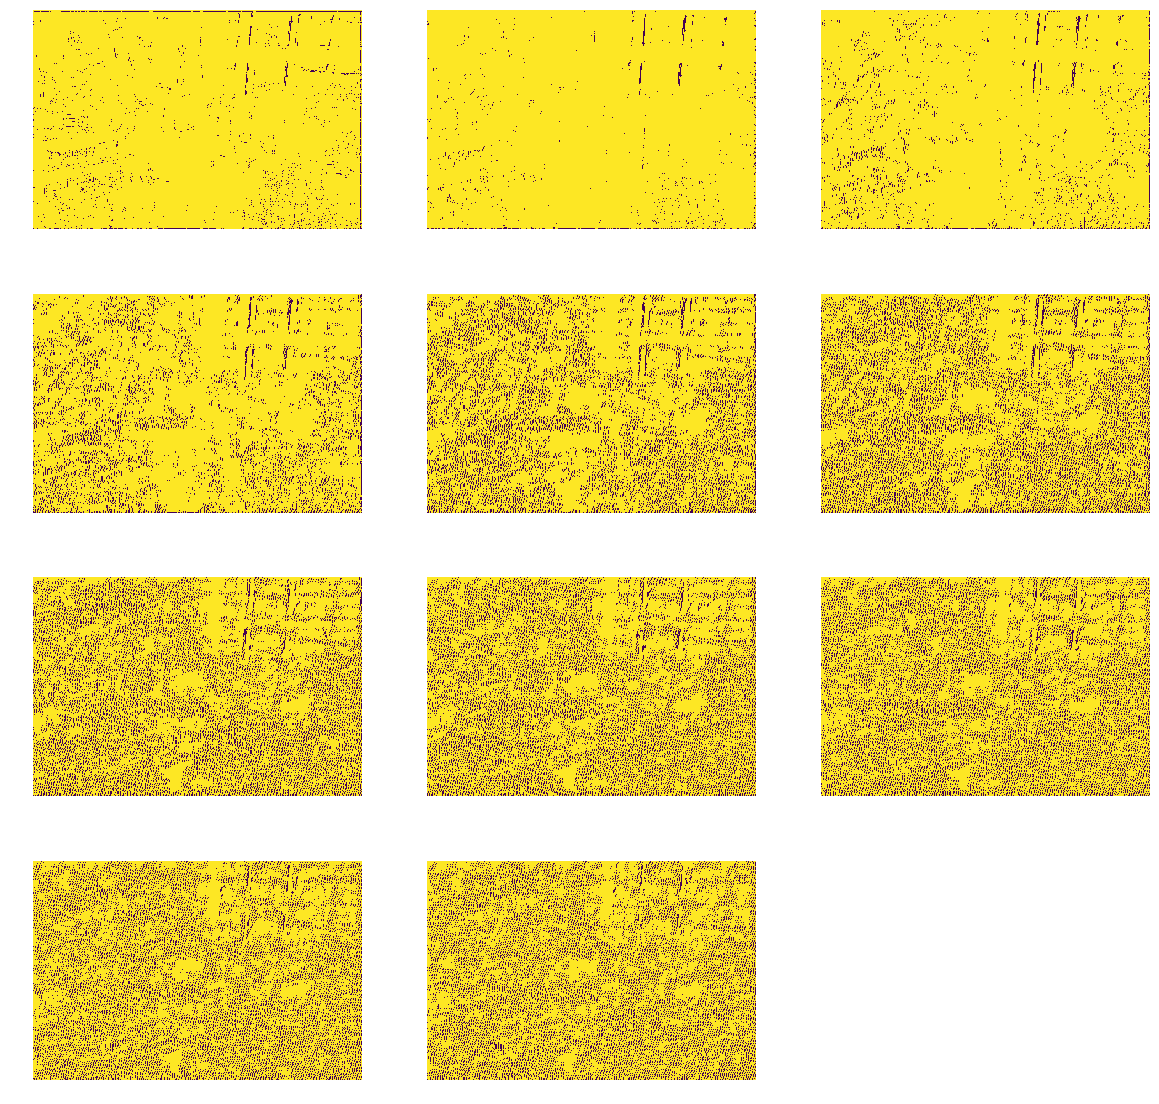

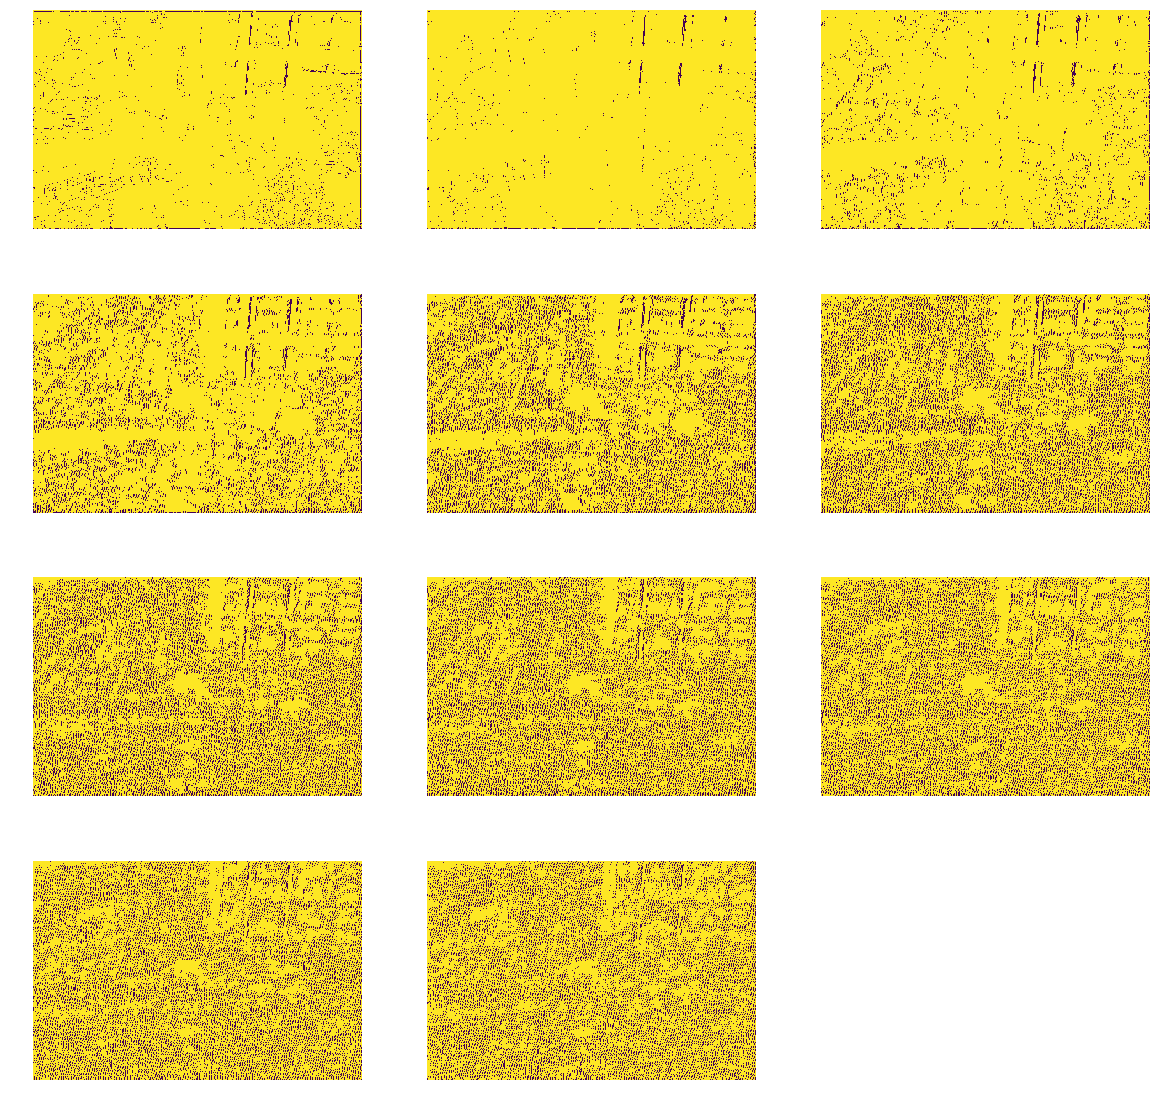

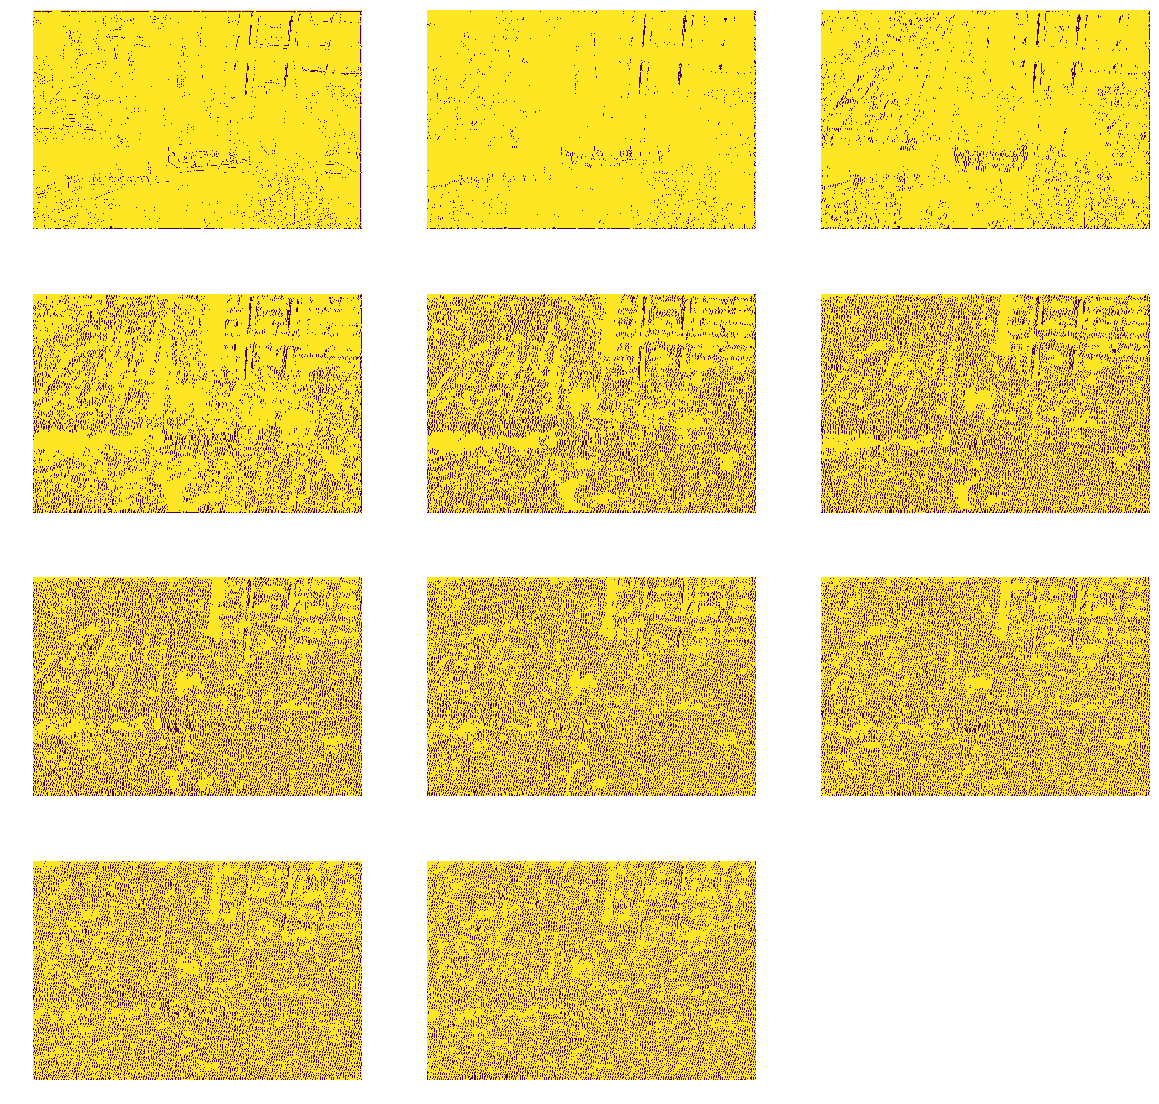

In [36]:
# Running RNN for one clip
frame_every = 20
path = 'videos/'
frames = {}

iClip = '002'
videofile = path+'mv2_'+iClip+'.avi'
cap = cv2.VideoCapture(videofile)
for i in tqdm(range(10)):
    X_sample = []
    y_sample = []
    
    # Save clips
    for iFrame in range(1+i*200, 1+(i+1)*200+1, frame_every):
        cap.set(1, iFrame)
        ret, frame = cap.read()
        if ret:
                X_sample.append(torch.from_numpy(frame))
        if (iFrame-1)%200 == 0:
            tmp = np.zeros(X_sample[0].shape[0:2])
            for d in bbox[iClip][iFrame]:
                x, y, dx, dy = d
                tmp[y:y+dy, x:x+dx] = 1
            y_sample.append(torch.from_numpy(tmp))
    
    # Train
    train_model_RNN(X_sample, y_sample, model, optimizer, H = y_sample[0])
